In [576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import sklearn
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import re
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [577]:
df = pd.read_csv("datasets/cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


In [578]:
import re

def clean_color(text):
     # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [579]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

In [580]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))


df["discard"] = (df.text.str.contains(r"[dD]iscard"))


df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))



In [581]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,draw,discard,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# STOP WORDS

In [582]:
# Exibir todas as colunas e amostras de valores únicos em texto
print("\nNomes das colunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())


Nomes das colunas e valores únicos:

Coluna: Unnamed: 0
[    1     2     4 ... 76228 76231 76232]

Coluna: name
["Ancestor's Chosen" 'Angel of Mercy' 'Angelic Blessing' ...
 'Vastwood Fortification // Vastwood Thicket' 'Veteran Adventurer'
 'Vine Gecko']

Coluna: multiverse_id
[    nan 129465. 129711. ... 491866. 491869. 491870.]

Coluna: text
["First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."
 'Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.'
 "Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.)"
 ... 'When Turntimber Ascetic enters the battlefield, you gain 3 life.'
 'Veteran Adventurer is also a Cleric, Rogue, Warrior, and Wizard.\r\nThis spell costs {1} less to cast for each creature in your party.\r\nVigilance'
 'The first kicked spell you cast ea

In [583]:
# Certifique-se de que os dados estão em formato de string antes de processar
df["flavor"] = df["flavor"].astype(str)  # Converte para string, caso não esteja

# Definir stop words
stop_words = set(stopwords.words("english"))  # Necessário baixar as stop words antes

stop_words.add('one')

# Define a função de preprocessamento
def preprocess(text, stop_words):
    # Remove pontuação e converte para minúsculas
    text = re.sub(r'[^\w\s]', '', text.lower())  
    # Tokeniza o texto
    tokens = word_tokenize(text)
    # Remove as stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]  
    return filtered_tokens

# Aplica a função a cada linha da coluna 'flavor'
df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words))

# Mostra o resultado
print(df["processed_flavor"])

0                                             [hand, done]
1                   [every, tear, shed, drop, immortality]
2        [warrior, admit, mortal, weakness, bolstered, ...
3                       [harmony, glorious, dirge, wicked]
4        [ancestor, protects, us, ways, cant, begin, co...
                               ...                        
12676        [standing, scythecat, prey, makes, appetizer]
12677    [long, land, cried, pain, flow, returns, balan...
12678    [understand, natures, ways, youre, never, unar...
12679                                         [assistance]
12680    [cute, things, tend, get, lot, bigger, youre, ...
Name: processed_flavor, Length: 12681, dtype: object


# TF IDF testes

In [584]:
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: ' '.join(x))

In [585]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

X = df
y = df['color']

# Codificar as classes (cores) como números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter as labels para one-hot encoding
y_one_hot = to_categorical(y_encoded)

df_train, df_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


In [586]:
# Agrupa os textos por cor e cria o TF-IDF existente
df_grouped = df_train.groupby('color')['processed_flavor'].apply(lambda x: ' '.join(x)).reset_index()

# Inicializa o TfidfVectorizer e ajusta com os textos agrupados por cor
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_grouped['processed_flavor'])

# Converte a matriz TF-IDF para um DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']
)

# Calcula o TF-IDF para as frases individuais (não agrupadas)
X = vectorizer.transform(df['processed_flavor'])

In [587]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Exibir o top 20
print(top_tfidf_all)

      color     word     tfidf
3367      B    death  0.330180
22158     G   forest  0.255104
75174     W    light  0.210239
41762     R     like  0.209166
39397     R  goblins  0.201606
58474     U     like  0.191901
64972     U     time  0.191901
8307      B     life  0.185281
62707     U      sea  0.183792
3347      B     dead  0.178155
25019     G     life  0.177871
1516      B    blood  0.168653
26262     G   nature  0.166169
59246     U     mind  0.162170
82871     W      war  0.160632
25050     G     like  0.154467
75155     W     life  0.153545
21045     G    elves  0.149424
58079     U     know  0.148656
8338      B     like  0.142524


In [588]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente para pegar as 20 palavras mais relevantes
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Pegar as 20 palavras mais relevantes
top_20_words = top_tfidf_all['word'].unique()

# Filtrar a matriz TF-IDF para as 20 palavras mais relevantes
filtered_tfidf = tfidf_df[top_20_words]

# Exibir o TF-IDF das 20 palavras para as 5 cores específicas
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()[:5]]  # Aqui você pode ajustar o número de cores ou selecionar específicas
print(top_20_tfidf)

          death    forest     light      like   goblins      time      life  \
color                                                                         
W      0.085040  0.007087  0.210239  0.118112  0.016536  0.099214  0.153545   
U      0.062165  0.005406  0.035137  0.191901  0.018920  0.191901  0.064868   
B      0.330180  0.009502  0.035631  0.142524  0.007126  0.085514  0.185281   
R      0.070562  0.002520  0.037801  0.209166  0.201606  0.090723  0.068042   
G      0.081914  0.255104  0.030425  0.154467  0.004681  0.093616  0.177871   

            sea      dead     blood    nature      mind       war     elves  \
color                                                                         
W      0.016536  0.054331  0.051969  0.009449  0.035434  0.160632  0.016758   
U      0.183792  0.032434  0.027028  0.043245  0.162170  0.048651  0.000000   
B      0.023754  0.178155  0.168653  0.019003  0.085514  0.045133  0.011234   
R      0.020161  0.047881  0.131044  0.020161  0.04

In [589]:
# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in tfidf_df.columns:
    if all(tfidf_df[word] > 0.1) and tfidf_sum[word] > 0.6:
        words_to_remove.append(word)

words_to_remove.append('color')
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

# Exibir as palavras removidas
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['like', 'color']


In [590]:
# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in tfidf_df.columns:
    if all(tfidf_df[word] > 0.1) and tfidf_sum[word] > 0.2:
        words_to_remove.append(word)
def remove_words(text, words_to_remove):
    # Divide o texto em palavras
    words = text.split()
    # Filtra as palavras, removendo as que estão na lista 'words_to_remove'
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    # Junta as palavras restantes de volta em uma string
    return ' '.join(filtered_words)
            
words_to_remove.append('color')
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

# Aplicar a função à coluna 'processed_flavor'
df_train['processed_flavor'] = df_train['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))

# Exibir as palavras removidas
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['like', 'color']


In [591]:
from nltk.tokenize import word_tokenize

all_words = []

for message in df['processed_flavor']:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

# Print the result
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 18745
Most common words: [('like', 419), ('never', 390), ('even', 344), ('life', 340), ('death', 323), ('every', 320), ('world', 289), ('time', 288), ('see', 288), ('dont', 281), ('us', 280), ('would', 265), ('must', 247), ('know', 244), ('many', 237)]


In [592]:
print(df['color'].value_counts())


color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [593]:
print(tfidf_df)

             07        10      1000    100000      1008     115th        12  \
color                                                                         
B      0.000000  0.000000  0.004022  0.000000  0.000000  0.004985  0.000000   
G      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
R      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.005289   
U      0.005672  0.005672  0.004576  0.005672  0.000000  0.000000  0.000000   
W      0.000000  0.000000  0.000000  0.000000  0.004957  0.000000  0.000000   

          136iv      1422     15000  ...     zurdi  zwinkerte       zyd  \
color                                ...                                  
B      0.000000  0.000000  0.000000  ...  0.000000   0.000000  0.000000   
G      0.000000  0.000000  0.000000  ...  0.007925   0.000000  0.007925   
R      0.000000  0.000000  0.000000  ...  0.000000   0.000000  0.004267   
U      0.000000  0.005672  0.005672  ...  0.004576   0.000000  0.000000

In [594]:
df_tfidf_prever = df_test.copy()

In [595]:
import math

def calculate_color_score(tfidf_df, terms):
    # Inicializa as pontuações para cada cor como 0
    color_scores = {color: 0 for color in tfidf_df.index}
    
    # Garantir que os termos sejam strings e limpos de espaços extras
    terms = terms.strip()  # Remove espaços no início e fim da string
    for term in terms.split():  # Divide em palavras com base em espaços
        if term in tfidf_df.columns:
            for color in tfidf_df.index:
                # Acessa o valor na célula do DataFrame e atualiza a pontuação
                #print('this is:', term, 'color',color,' pontuation:', tfidf_df.loc[color, term])  # Debug: verifique o termo completo
                color_scores[color] += tfidf_df.loc[color, term]
    print(color_scores)
    # Normaliza as pontuações usando a função sigmoide
    color_scores = {color: 1 / (1 + math.exp(-score)) for color, score in color_scores.items()}
    return color_scores

In [596]:
df_tfidf_prever['test_color'] = df_tfidf_prever['processed_flavor'].apply(lambda phrase: calculate_color_score(tfidf_df, phrase))

# Determina a cor com a maior pontuação para cada frase
df_tfidf_prever['predicted_color'] = df_tfidf_prever['test_color'].apply(lambda x: max(x, key=x.get))

# Calcula a precisão (accuracy) comparando cor real com cor prevista
accuracy = accuracy_score(df_tfidf_prever['color'], df_tfidf_prever['predicted_color'])

# Exibe o DataFrame final e a precisão
print(df_tfidf_prever[['processed_flavor', 'color', 'predicted_color']])
print(f"Acc: {accuracy:.2f}")


{'B': 0.0056169701976566165, 'G': 0.03438117134260606, 'R': 0.00893860686703608, 'U': 0.025130632020175417, 'W': 0.009585458256945378}
{'B': 0.009735838336410372, 'G': 0.00630304641688809, 'R': 0.01032879866403153, 'U': 0.021007971903202874, 'W': 0.004724471972230564}
{'B': 0.004750797416641788, 'G': 0.012650960083878856, 'R': 0.0546263728776373, 'U': 0.005405656378831048, 'W': 0.019409064711268662}
{'B': 0.010852284350226823, 'G': 0.011068429836961609, 'R': 0.020186332484682684, 'U': 0.03842522556444056, 'W': 0.023550070900037995}
{'B': 0.10837010834239663, 'G': 0.1567911247449015, 'R': 0.1612676112955521, 'U': 0.17992353163331254, 'W': 0.24247893523588143}
{'B': 0.10686677459287808, 'G': 0.07278324711370834, 'R': 0.1260036072768911, 'U': 0.1361854967594233, 'W': 0.11030023257489603}
{'B': 0.12991803116670664, 'G': 0.0725524547391819, 'R': 0.13328755263421443, 'U': 0.09622795330083242, 'W': 0.12870620718826103}
{'B': 0.17516072801679788, 'G': 0.18021093596506468, 'R': 0.17481785894953

# REDE NEURONAL

In [597]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Preparar as variáveis X e y
X = np.array([list(color.values()) for color in df_tfidf_prever['test_color']])  # Converter os dicionários em listas de pontuações
y = df_tfidf_prever['color']

# Codificar as classes (cores) como números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter as labels para one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout\nfrom keras.utils import to_categorical\n\n# Preparar as variáveis X e y\nX = np.array([list(color.values()) for color in df_tfidf_prever['test_color']])  # Converter os dicionários em listas de pontuações\ny = df_tfidf_prever['color']\n\n# Codificar as classes (cores) como números\nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y)\n\n# Converter as labels para one-hot encoding\ny_one_hot = to_categorical(y_encoded)\n\n# Dividir os dados em treino e teste (80% treino, 20% teste)\nX_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)\n"

In [598]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD 
# Criar o modelo
model = Sequential()

# Camada de entrada com 128 neurônios e função de ativação 'relu'
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Camada oculta adicional 1
model.add(Dense(64, activation='relu'))

# Camada oculta adicional 2
model.add(Dense(32, activation='relu'))

# Camada de Dropout para prevenir overfitting
model.add(Dropout(0.2))

# Camada de saída com a função de ativação 'softmax' (para classificação multiclasse)
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Compilar o modelo com o otimizador 'adam' e a função de perda 'categorical_crossentropy'
sgd_optimizer = SGD(learning_rate=0.01)  # Definindo a taxa de aprendizado do SGD
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Input\nfrom keras.utils import to_categorical\nfrom keras.optimizers import SGD \n# Criar o modelo\nmodel = Sequential()\n\n# Camada de entrada com 128 neurônios e função de ativação 'relu'\nmodel.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))\n\n# Camada oculta adicional 1\nmodel.add(Dense(64, activation='relu'))\n\n# Camada oculta adicional 2\nmodel.add(Dense(32, activation='relu'))\n\n# Camada de Dropout para prevenir overfitting\nmodel.add(Dropout(0.2))\n\n# Camada de saída com a função de ativação 'softmax' (para classificação multiclasse)\nmodel.add(Dense(y_one_hot.shape[1], activation='softmax'))\n\n# Compilar o modelo com o otimizador 'adam' e a função de perda 'categorical_crossentropy'\nsgd_optimizer = SGD(learning_rate=0.01)  # Definindo a

In [599]:
'''
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))
'''

'\n# Treinar o modelo\nhistory = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))\n'

In [600]:
'''
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acc no conjunto de teste: {accuracy:.4f}')
'''

"\n# Avaliar o modelo\nloss, accuracy = model.evaluate(X_test, y_test)\nprint(f'Acc no conjunto de teste: {accuracy:.4f}')\n"

In [601]:
'''
# Fazer previsões com novos dados (aqui usamos X_test como exemplo)
y_pred = model.predict(X_test)

# Converter a previsão (vetor de probabilidades) para a classe com maior probabilidade
y_pred_classes = np.argmax(y_pred, axis=1)

# Decodificar a classe de volta para a cor
predicted_colors = label_encoder.inverse_transform(y_pred_classes)

# Mostrar as previsões
print(f'Previsões: {predicted_colors}')
'''

"\n# Fazer previsões com novos dados (aqui usamos X_test como exemplo)\ny_pred = model.predict(X_test)\n\n# Converter a previsão (vetor de probabilidades) para a classe com maior probabilidade\ny_pred_classes = np.argmax(y_pred, axis=1)\n\n# Decodificar a classe de volta para a cor\npredicted_colors = label_encoder.inverse_transform(y_pred_classes)\n\n# Mostrar as previsões\nprint(f'Previsões: {predicted_colors}')\n"

# PREVISOES COM FEATURES

In [602]:
df_prever = df.copy()

In [603]:
df_prever.columns

Index(['Unnamed: 0', 'name', 'multiverse_id', 'text', 'flavor', 'power',
       'color', 'counterspell', 'exile', 'fight', 'mill', 'scry', 'tap',
       'untap', 'double_strike', 'first_strike', 'flash', 'flying', 'haste',
       'hexproof', 'indestructible', 'sacrifice', 'lifelink', 'menace',
       'protection', 'prowess', 'reach', 'trample', 'vigilance', 'draw',
       'discard', 'damage', 'damage_prevention', 'life_gain', 'life_loss',
       'tokens', 'destroy', 'return', 'recursion', 'processed_flavor'],
      dtype='object')

In [604]:
df_prever = df_prever.drop(columns=['Unnamed: 0', 'multiverse_id','text','flavor','processed_flavor','name'])

In [605]:
df_prever.isnull().sum()

power                5310
color                   0
counterspell            0
exile                   0
fight                 289
mill                  289
scry                  289
tap                   289
untap                 289
double_strike         289
first_strike          289
flash                   0
flying                289
haste                 289
hexproof              289
indestructible          0
sacrifice             289
lifelink              289
menace                289
protection            289
prowess               289
reach                   0
trample               289
vigilance             289
draw                  289
discard               289
damage                289
damage_prevention     289
life_gain             289
life_loss               0
tokens                289
destroy                 0
return                  0
recursion               0
dtype: int64

In [606]:
df_prever = df_prever.dropna() 

In [607]:
# Convertendo colunas booleanas em 0 e 1
boolean_columns = ['counterspell', 'exile', 'fight', 'mill', 'scry', 'tap', 'untap', 
                   'double_strike', 'first_strike', 'flash', 'flying', 'haste', 'hexproof', 
                   'indestructible', 'sacrifice', 'lifelink', 'menace', 'protection', 'prowess', 
                   'reach', 'trample', 'vigilance', 'draw', 'discard', 'damage', 'damage_prevention', 
                   'life_gain', 'life_loss', 'tokens', 'destroy', 'return', 'recursion']

# Convertendo as colunas booleanas para inteiros (0 ou 1)
df_prever[boolean_columns] = df_prever[boolean_columns].astype(int)

# Mapeando as cores para números
color_mapping = {
    'G': 1,  # Verde
    'R': 2,  # Vermelho
    'U': 3,  # Azul
    'W': 4,  # Branco
    'B': 5   # Preto
}

# Aplicando o mapeamento à coluna 'color'
df_prever['color'] = df_prever['color'].map(color_mapping)
# Caso a coluna 'color' tenha valores ausentes ou errados, podemos tratar com um valor padrão, por exemplo, 0
df_prever['color'] = df_prever['color'].fillna(0).astype(int)

# Tratando a coluna 'power' (convertendo para float, se necessário)
# Se a coluna 'power' contiver valores de texto como '*', podemos substituir por NaN antes da conversão
df_prever['power'] = pd.to_numeric(df_prever['power'], errors='coerce')

# Verificando o resultado
print(df_prever.head())

   power  color  counterspell  exile  fight  mill  scry  tap  untap  \
0    4.0      4             0      0      0     0     0    0      0   
1    3.0      4             0      0      0     0     0    0      0   
4    0.0      4             0      0      0     0     0    0      0   
6    2.0      4             0      0      0     0     0    0      0   
7    2.0      4             0      0      0     0     0    0      0   

   double_strike  ...  draw  discard  damage  damage_prevention  life_gain  \
0              0  ...     0        0       0                  0          1   
1              0  ...     0        0       0                  0          1   
4              0  ...     0        0       0                  0          0   
6              0  ...     0        0       0                  0          0   
7              0  ...     0        0       0                  0          0   

   life_loss  tokens  destroy  return  recursion  
0          0       0        0       0          0  
1 

In [608]:
df_prever.columns

Index(['power', 'color', 'counterspell', 'exile', 'fight', 'mill', 'scry',
       'tap', 'untap', 'double_strike', 'first_strike', 'flash', 'flying',
       'haste', 'hexproof', 'indestructible', 'sacrifice', 'lifelink',
       'menace', 'protection', 'prowess', 'reach', 'trample', 'vigilance',
       'draw', 'discard', 'damage', 'damage_prevention', 'life_gain',
       'life_loss', 'tokens', 'destroy', 'return', 'recursion'],
      dtype='object')

In [609]:
print(df_prever.dtypes)

power                float64
color                  int32
counterspell           int32
exile                  int32
fight                  int32
mill                   int32
scry                   int32
tap                    int32
untap                  int32
double_strike          int32
first_strike           int32
flash                  int32
flying                 int32
haste                  int32
hexproof               int32
indestructible         int32
sacrifice              int32
lifelink               int32
menace                 int32
protection             int32
prowess                int32
reach                  int32
trample                int32
vigilance              int32
draw                   int32
discard                int32
damage                 int32
damage_prevention      int32
life_gain              int32
life_loss              int32
tokens                 int32
destroy                int32
return                 int32
recursion              int32
dtype: object


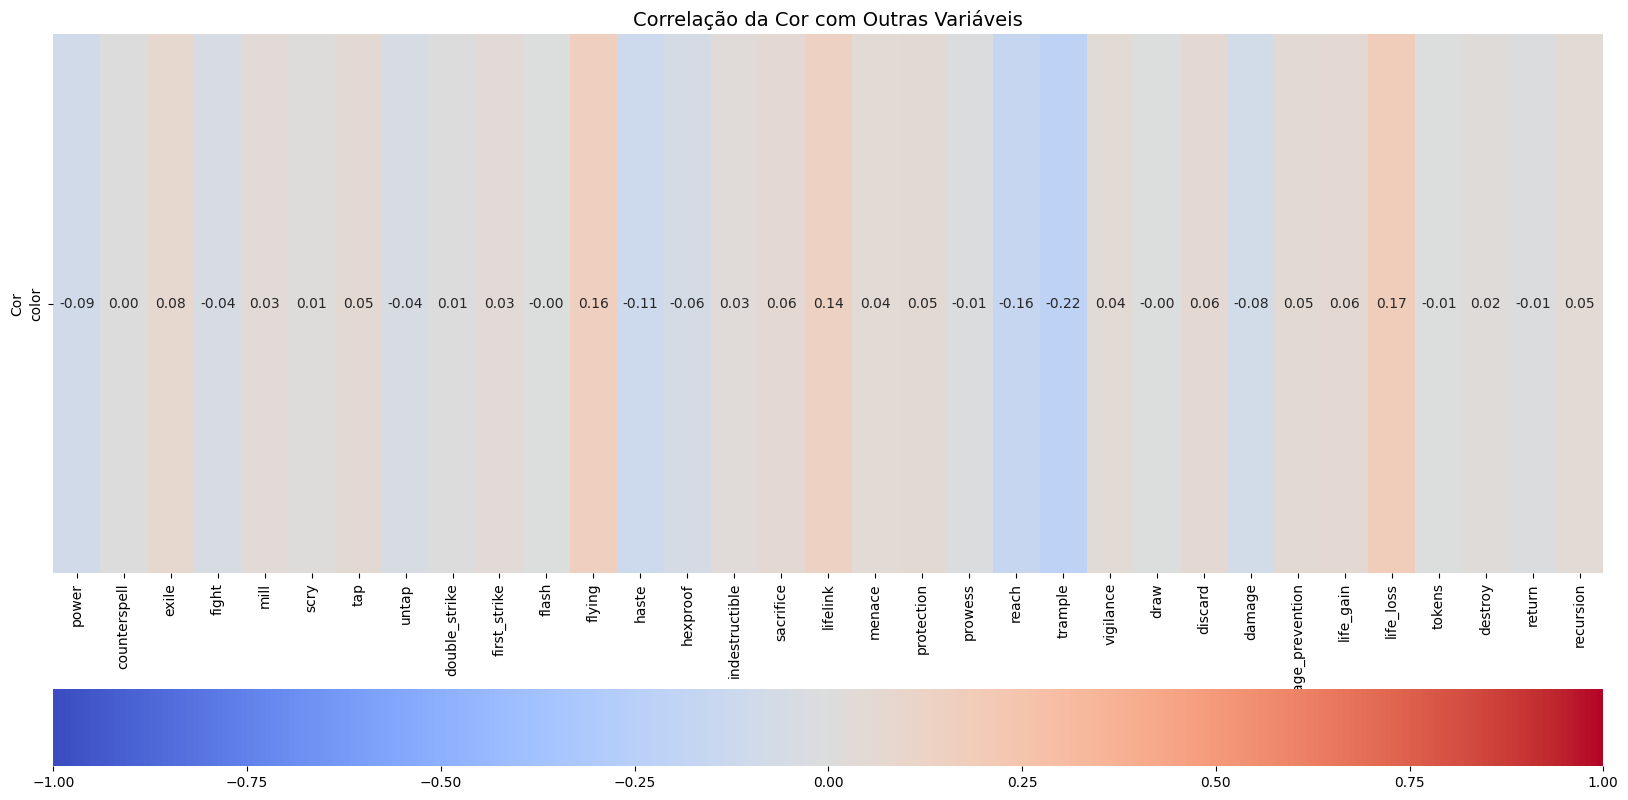

In [610]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar colunas relevantes
selected_columns = ['color', 'counterspell', 'flying', 'haste', 'hexproof', 'indestructible', 
                    'lifelink', 'menace', 'protection', 'trample', 'vigilance', 'damage']

# Subset do DataFrame com as colunas selecionadas
df_selected = df_prever

# Calcular a matriz de correlação
correlation_matrix = df_selected.corr()

# Focar apenas nas correlações da variável `color` com as outras
color_correlation = correlation_matrix.loc[['color'], correlation_matrix.columns != 'color']

# Criar o heatmap
plt.figure(figsize=(20, 10))  # Tamanho ajustado para o gráfico horizontal
sns.heatmap(color_correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlação da Cor com Outras Variáveis', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Cor')
plt.show()



In [611]:
df_prever_ml = df_prever[['exile', 'flying', 'lifelink', 'life_loss','color']]

In [612]:
from sklearn.model_selection import train_test_split

X = df_prever_ml.drop('color', axis=1)  # Atributos
y = df_prever_ml['color']  # Alvo (cor da carta)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [613]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [614]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.3048694424841214
              precision    recall  f1-score   support

           1       0.27      0.94      0.42       314
           2       0.00      0.00      0.00       277
           3       0.36      0.38      0.37       256
           4       0.56      0.06      0.11       298
           5       0.92      0.08      0.15       272

    accuracy                           0.30      1417
   macro avg       0.42      0.29      0.21      1417
weighted avg       0.42      0.30      0.21      1417



C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarnin

# WORLD CLOUD

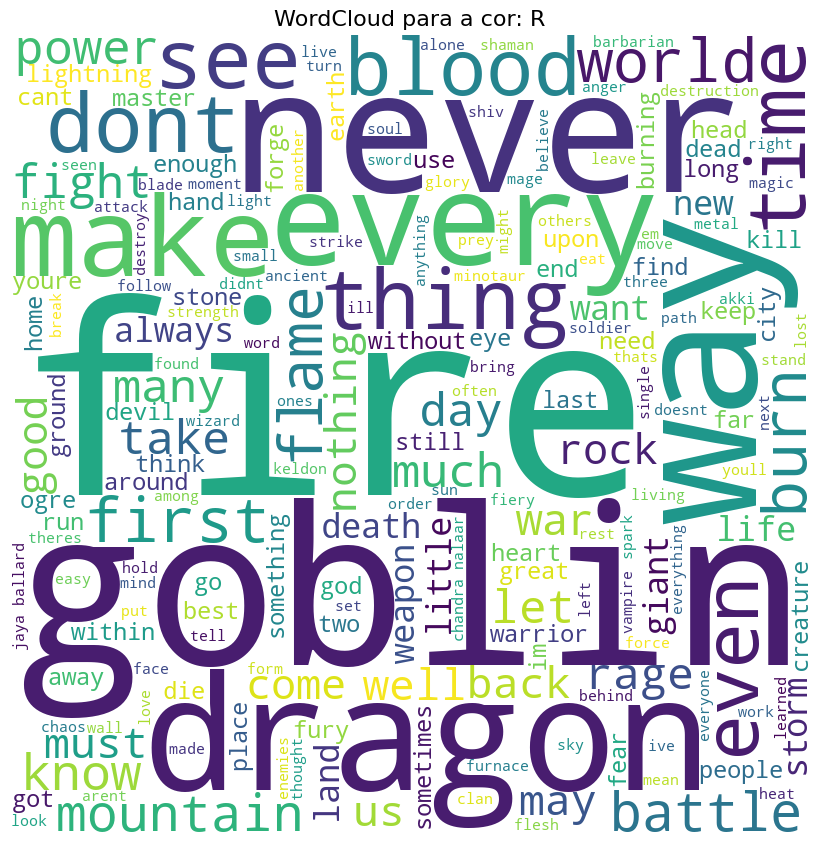

In [615]:
# Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    # Filtra as linhas onde a coluna 'color' contém a cor desejada
    filtered_words = df[df['color'].str.contains(cor, case=False, na=False)]['processed_flavor']

    # Cria uma string com todas as palavras filtradas
    comment_words = ' '.join(filtered_words)

    # Verifica se há palavras filtradas antes de gerar o WordCloud
    if comment_words:
        # Gerar o WordCloud com o texto filtrado
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        # Exibe a imagem do WordCloud para a cor
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Adiciona título com o nome da cor
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

# Escolha a cor desejada para o WordCloud
cor_escolhida = 'R'  # Exemplo: 'red', pode substituir por qualquer cor

# Chama a função para gerar o WordCloud para a cor escolhida
gerar_wordcloud_cor(cor_escolhida, df)
